In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow --upgrade


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DATA_CSIT696/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")


In [ ]:
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
# Read the dataset with the specified encoding and column names
data = pd.read_csv("/content/drive/MyDrive/DATA_CSIT696/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", names=DATASET_COLUMNS)

In [ ]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Dataset details
# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
# ids: The id of the tweet ( 2087)
# date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# flag: The query (lyx). If there is no query, then this value is NO_QUERY.
# user: the user that tweeted (robotickilldozr)
# text: the text of the tweet (Lyx is cool)

In [ ]:
print("Dataset size:", len(data))

Dataset size: 1600000


In [ ]:
# Map target label to String
# 0 -> NEGATIVE
# 2 -> NEUTRAL
# 4 -> POSITIVE

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
data.target = data.target.apply(lambda x: decode_sentiment(x))

CPU times: user 724 ms, sys: 1.85 ms, total: 726 ms
Wall time: 1.55 s


Text(0.5, 1.0, 'Dataset labels distribuition')

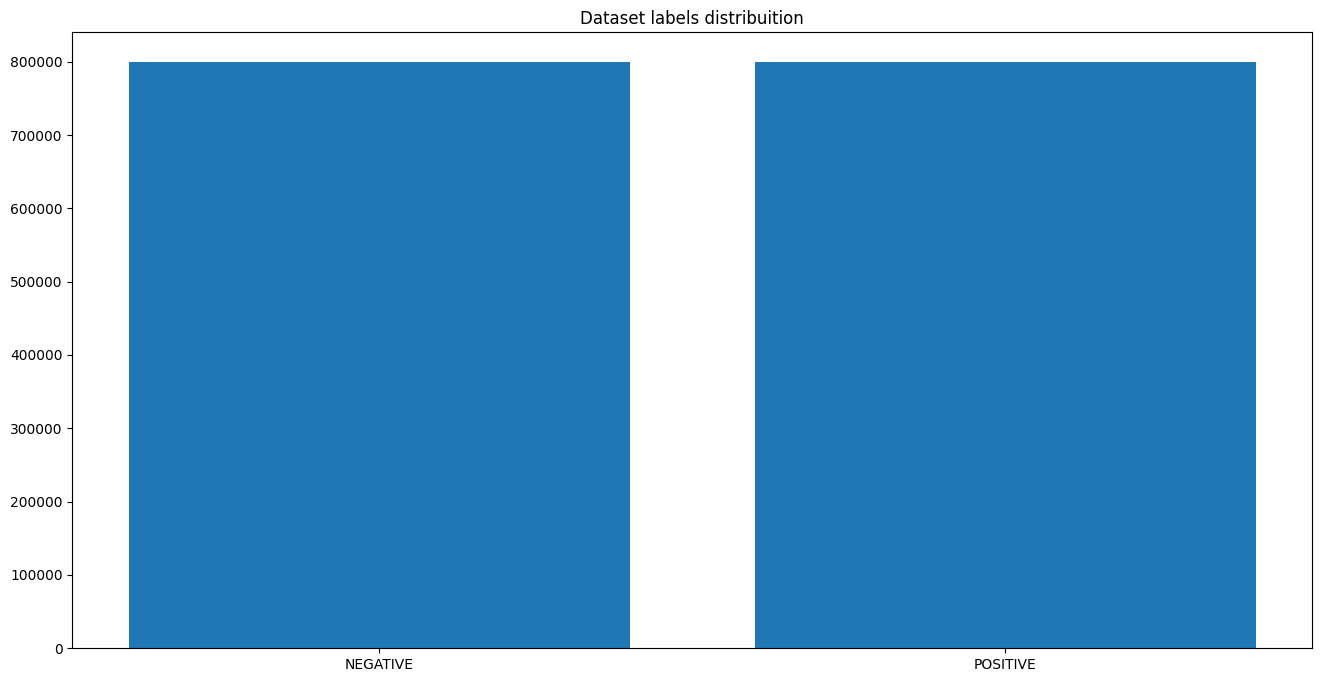

In [ ]:
target_cnt = Counter(data.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
#PRE-PROCESS
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
data.text = data.text.apply(lambda x: preprocess(x))

CPU times: user 1min 3s, sys: 300 ms, total: 1min 3s
Wall time: 1min 14s


In [ ]:
# Split train and test

data_train, data_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(data_train))
print("TEST size:", len(data_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
# Word2Vec
%%time
documents = [_text.split() for _text in data_train.text]

CPU times: user 3.46 s, sys: 250 ms, total: 3.71 s
Wall time: 3.71 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = list(w2v_model.wv.index_to_key)  # Get the vocabulary words
vocab_size = len(words)
print("Vocab size:", vocab_size)


Vocab size: 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 20min 37s, sys: 6.6 s, total: 20min 44s
Wall time: 13min 19s


(263129007, 295270528)

In [ ]:
similar_words = w2v_model.wv.most_similar("love", topn=10)
print(similar_words)

[('luv', 0.573758602142334), ('loves', 0.5565868020057678), ('loved', 0.5408453345298767), ('adore', 0.5270845890045166), ('looove', 0.5109463334083557), ('amazing', 0.5039474368095398), ('awesome', 0.469946950674057), ('loveee', 0.457581102848053), ('lovee', 0.4400767683982849), ('miss', 0.43051257729530334)]


In [ ]:
similar_words = w2v_model.wv.most_similar("hate", topn=10)
print(similar_words)

[('hates', 0.5689560770988464), ('sucks', 0.5043128728866577), ('dislike', 0.4704170823097229), ('stupid', 0.46283841133117676), ('suck', 0.45095333456993103), ('hating', 0.44057390093803406), ('ugh', 0.4222714900970459), ('despise', 0.416463166475296), ('h8', 0.4154508113861084), ('annoying', 0.4003007113933563)]


In [ ]:
# Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 19 s, sys: 167 ms, total: 19.2 s
Wall time: 19.2 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(data_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(data_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 25.3 s, sys: 515 ms, total: 25.8 s
Wall time: 26 s


In [ ]:
# Label Encoder

In [ ]:
labels = data_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(data_train.target.tolist())

y_train = encoder.transform(data_train.target.tolist())
y_test = encoder.transform(data_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
# Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
# Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


In [ ]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
# Callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
# Train
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.7498

1125/1125 [==============================] - 598s 523ms/step - loss: 0.5049 - accuracy: 0.7498 - val_loss: 0.4651 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.7676

1125/1125 [==============================] - 592s 527ms/step - loss: 0.4787 - accuracy: 0.7676 - val_loss: 0.4581 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7722

1125/1125 [==============================] - 585s 520ms/step - loss: 0.4719 - accuracy: 0.7722 - val_loss: 0.4537 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.7744

1125/1125 [==============================] - 579s 514ms/step - loss: 0.4678 - accuracy: 0.7744 - val_loss: 0.4514 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.7753

1125/1125 [==============================] - 581s 516ms/step - loss: 0.4659 - accuracy: 0.7753 - val_loss: 0.4515 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7769

1125/1125 [==============================] - 584s 519ms/step - loss: 0.4638 - accuracy: 0.7769 - val_loss: 0.4483 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.7778

1125/1125 [==============================] - 582s 517ms/step - loss: 0.4627 - accuracy: 0.7778 - val_loss: 0.4478 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.7780

1125/1125 [==============================] - 583s 518ms/step - loss: 0.4619 - accuracy: 0.7780 - val_loss: 0.4480 - val_accuracy: 0.7899 - lr: 0.0010
CPU times: user 1h 24min 8s, sys: 3min 37s, total: 1h 27min 46s
Wall time: 1h 18min 25s


In [ ]:
#EVALUATE

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 36s 113ms/step - loss: 0.4471 - accuracy: 0.7910

ACCURACY: 0.7910374999046326
LOSS: 0.4471084475517273
CPU times: user 31.5 s, sys: 2.9 s, total: 34.4 s
Wall time: 36.7 s


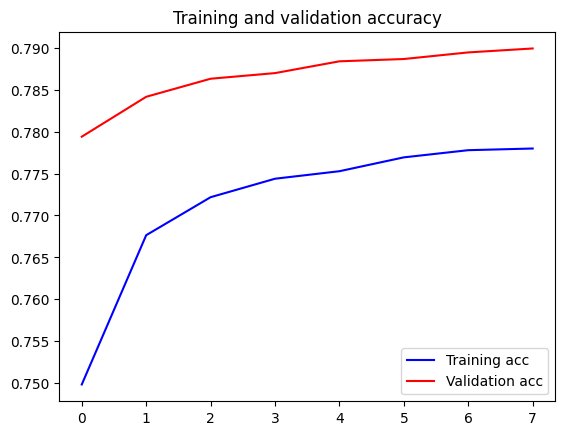

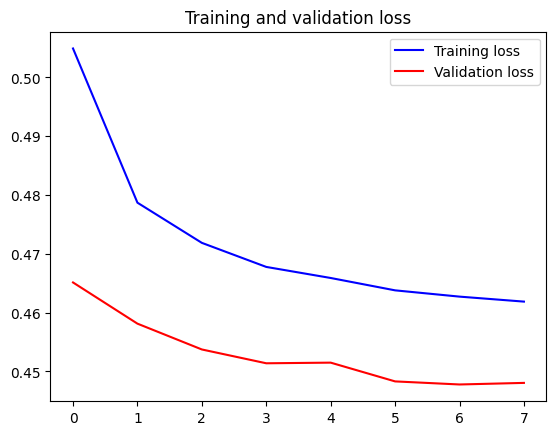

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#PREDICT

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I love chicken")

1/1 [==============================] - 0s 331ms/step


{'label': 'POSITIVE',
 'score': 0.9036518335342407,
 'elapsed_time': 0.43719005584716797}

In [ ]:
predict("I hate veggies")

1/1 [==============================] - 0s 105ms/step


{'label': 'NEGATIVE',
 'score': 0.05497121438384056,
 'elapsed_time': 0.149857759475708}

In [ ]:
predict("the refree is unbiased")

1/1 [==============================] - 0s 88ms/step


{'label': 'NEUTRAL',
 'score': 0.5537270903587341,
 'elapsed_time': 0.13032102584838867}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(data_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 22s 552ms/step
CPU times: user 14.3 s, sys: 9.27 s, total: 23.5 s
Wall time: 42.2 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

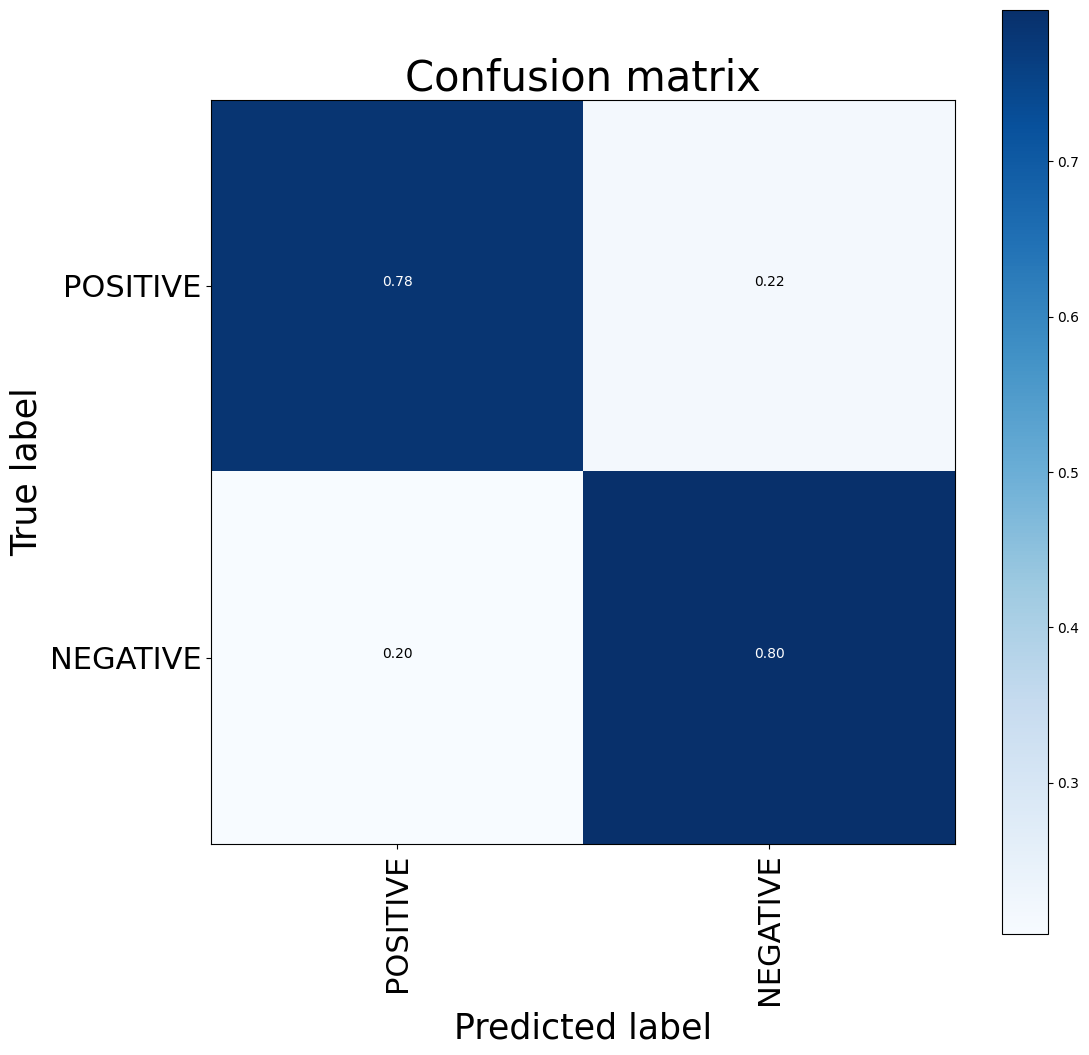

CPU times: user 1.36 s, sys: 277 ms, total: 1.64 s
Wall time: 1.38 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=data_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
similar_words = w2v_model.wv.most_similar("neutral", topn=10)
print(similar_words)

[('frock', 0.31420138478279114), ('excellence', 0.3077467978000641), ('cisco', 0.2969256639480591), ('ph', 0.2906858026981354), ('italians', 0.29024001955986023), ('mashable', 0.2817082703113556), ('apache', 0.28105607628822327), ('prem', 0.2705627977848053), ('smugmug', 0.2663116753101349), ('premiership', 0.2654188871383667)]
